In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
# ------------------------------
# Load Churn Training Data
# ------------------------------
data = pd.read_excel("Churn_Data.xlsx", sheet_name="vw_ChurnData")
print(data.head())

  Data.Customer_ID Data.Gender  Data.Age Data.Married      Data.State  \
0        11098-MAD      Female        30          Yes  Madhya Pradesh   
1        11114-PUN        Male        51           No          Punjab   
2        11167-WES      Female        43          Yes     West Bengal   
3        11179-MAH        Male        35           No     Maharashtra   
4        11180-TAM        Male        75          Yes      Tamil Nadu   

   Data.Number_of_Referrals Data.Value_Deal Data.Phone_Service  \
0                         0          Deal 1                Yes   
1                         5          Deal 5                Yes   
2                         3          Deal 1                Yes   
3                        10             NaN                Yes   
4                        12          Deal 2                Yes   

  Data.Multiple_Lines Data.Internet_Service  ... Data.Premium_Support  \
0                  No                   Yes  ...                  Yes   
1                 

In [5]:
data.columns = data.columns.str.replace("Data.", "", regex=False)


In [7]:
# Drop columns not used for prediction
data = data.drop(['Customer_ID'], axis=1)

# Columns to label encode
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

In [9]:
# Encode categorical columns
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Encode target column
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

In [11]:
# Split into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [29]:
# Initialize Random Forest with default settings
rf_model = RandomForestClassifier(random_state=42, class_weight ="balanced")

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       855
           1       0.72      0.57      0.64       347

    accuracy                           0.81      1202
   macro avg       0.78      0.74      0.75      1202
weighted avg       0.80      0.81      0.80      1202


Confusion Matrix:
[[779  76]
 [150 197]]


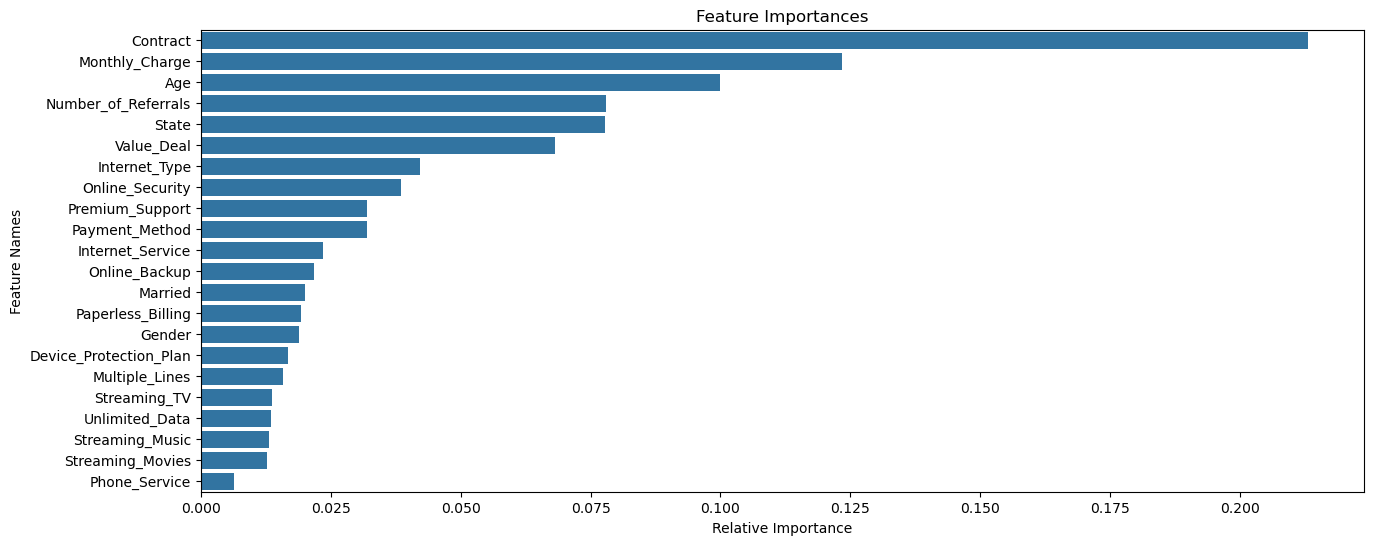

In [17]:
# ------------------------------
# Feature Importance Plot
# ------------------------------
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

In [19]:
# ------------------------------
new_data = pd.read_excel("Churn_data.xlsx", sheet_name="vw_JoinData")
original_data = new_data.copy()
customer_ids = new_data['Data.Customer_ID']

In [21]:
new_data.columns = new_data.columns.str.replace("Data.", "", regex=False)

In [23]:
# Drop unused columns
new_data = new_data.drop(['Customer_ID'], axis=1)

# Encode categorical columns using previous label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

In [25]:
# Predict churn
new_predictions = rf_model.predict(new_data)

# Add predictions to original data
original_data['Customer_Status_Predicted'] = new_predictions

# Filter churned customers
original_data.to_csv("New_Predictions.csv", index=False)